In [6]:
import xarray as xr
import pandas as pd

# Load your downloaded NetCDF file
ds = xr.open_dataset('E:/Arbitrage_Model_project/wind-h2-arbitrage/DATA/Wind_data_ERA5/Reusenkoge_onshore_wind_data.nc')

print(ds)

<xarray.Dataset> Size: 281kB
Dimensions:     (valid_time: 8784, latitude: 1, longitude: 1)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-31T23...
  * latitude    (latitude) float64 8B 54.5
  * longitude   (longitude) float64 8B 8.8
    expver      (valid_time) <U4 141kB ...
Data variables:
    u100        (valid_time, latitude, longitude) float32 35kB ...
    v100        (valid_time, latitude, longitude) float32 35kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-21T15:49 GRIB to CDM+CF via cfgrib-0.9.1...


In [7]:
# 1. Load the CSV file:
# - header=0 reads the first row as the column names
# - skiprows=[1] skips the second junk row (at index 1)
df = pd.read_csv('E:/Arbitrage_Model_project/wind-h2-arbitrage/DATA/energy-charts_Electricity_production_and_spot_prices_in_Germany_in_2024.csv', 
                 header=0, 
                 skiprows=[1])

# 2. Rename the columns
df_prices_clean = df.rename(columns={
    'Date (GMT+1)': 'datetime',
    'Day Ahead Auction (DE-LU)': 'price_eur_mwh'
})

# 3. Convert the 'datetime' column to a real datetime object
df_prices_clean['datetime'] = pd.to_datetime(df_prices_clean['datetime'])

# 4. Set the 'datetime' as the index
df_prices_clean = df_prices_clean.set_index('datetime')

# 5. Keep only the price column
df_prices_clean = df_prices_clean[['price_eur_mwh']]

# 6. Convert the price column to a number
df_prices_clean['price_eur_mwh'] = pd.to_numeric(df_prices_clean['price_eur_mwh'])

# 7. Check your clean, ready-to-use price data!
print(df_prices_clean.head())

print("\nData information:")
df_prices_clean.info()

                           price_eur_mwh
datetime                                
2024-01-01 00:00:00+01:00           0.10
2024-01-01 01:00:00+01:00           0.01
2024-01-01 02:00:00+01:00           0.00
2024-01-01 03:00:00+01:00          -0.01
2024-01-01 04:00:00+01:00          -0.03

Data information:
<class 'pandas.core.frame.DataFrame'>
Index: 8784 entries, 2024-01-01 00:00:00+01:00 to 2024-12-31 23:00:00+01:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price_eur_mwh  8784 non-null   float64
dtypes: float64(1)
memory usage: 137.2+ KB


C:\Users\Madhvesh\AppData\Local\Temp\ipykernel_25404\3451944040.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prices_clean['datetime'] = pd.to_datetime(df_prices_clean['datetime'])


In [8]:
# 1. Load your downloaded NetCDF file
ds = xr.open_dataset('E:/Arbitrage_Model_project/wind-h2-arbitrage/DATA/Wind_data_ERA5/Reusenkoge_onshore_wind_data.nc')


# 2. Select the first latitude and longitude (at index 0)
#    This "flattens" the data from 3D (time, lat, lon) to 1D (time)
ds_at_point = ds.isel(latitude=0, longitude=0)

# 3. Calculate the total wind speed from the u/v components
wind_speed = (ds_at_point['u100']**2 + ds_at_point['v100']**2)**0.5

# 4. Convert this to a clean pandas DataFrame
df_wind = wind_speed.to_dataframe(name='wind_speed_ms')

# 5. NOW this will work. Convert the timezone (from UTC to CET/Berlin)
df_wind.index = df_wind.index.tz_localize('UTC').tz_convert('Europe/Berlin')

# Check your new wind DataFrame
print("--- Wind Data (Head) ---")
print(df_wind.head())


# 6. Join the two DataFrames on their datetime index
df_master = df_wind.join(df_prices_clean)

--- Wind Data (Head) ---
                           number  latitude  longitude expver  wind_speed_ms
valid_time                                                                  
2024-01-01 01:00:00+01:00       0      54.5        8.8   0001      10.982187
2024-01-01 02:00:00+01:00       0      54.5        8.8   0001      10.417537
2024-01-01 03:00:00+01:00       0      54.5        8.8   0001      10.251302
2024-01-01 04:00:00+01:00       0      54.5        8.8   0001      10.582304
2024-01-01 05:00:00+01:00       0      54.5        8.8   0001      10.894723


In [18]:
# 1. Clean up df_wind (from your output)
#    We only need the wind speed.
df_wind_clean = df_wind[['wind_speed_ms']]

# 2. Join with the price data (from your previous step)
#    (This assumes 'df_prices_clean' is still in your notebook's memory)
df_master = df_wind_clean.join(df_prices_clean)

# 3. Clean the final master DataFrame
#    This removes any hours that were in one file but not the other
#    (e.g., if one file had 8784 hours and the other 8760)
df_master = df_master.dropna()

# 4. Calculate Power Output (Same as before)
TOTAL_FARM_CAPACITY_MW = 210 

def calculate_power(wind_speed):
    if wind_speed < 3:  # Cut-in speed
        return 0.0
    elif wind_speed < 13: # Between cut-in and rated
        return (wind_speed - 3) / (13 - 3) * TOTAL_FARM_CAPACITY_MW
    elif wind_speed < 25: # Between rated and cut-out
        return TOTAL_FARM_CAPACITY_MW
    else: # Above cut-out speed
        return 0.0

# 5. Apply the function to create the new column
df_master['power_mw'] = df_master['wind_speed_ms'].apply(calculate_power)

# --- YOUR FOUNDATION IS BUILT ---

# 6. See the final, ready-to-use DataFrame
print("\n--- Final DataFrame for Modeling (Head) ---")
print(df_master.head())

# 7. Check the info to see how many hours we have
print("\n--- Final DataFrame Info (Post-Cleaning) ---")
df_master.info()


--- Final DataFrame for Modeling (Head) ---
                           wind_speed_ms  price_eur_mwh    power_mw
valid_time                                                         
2024-01-01 01:00:00+01:00      10.982187           0.01  167.625933
2024-01-01 02:00:00+01:00      10.417537           0.00  155.768271
2024-01-01 03:00:00+01:00      10.251302          -0.01  152.277337
2024-01-01 04:00:00+01:00      10.582304          -0.03  159.228384
2024-01-01 05:00:00+01:00      10.894723          -0.02  165.789182

--- Final DataFrame Info (Post-Cleaning) ---
<class 'pandas.core.frame.DataFrame'>
Index: 8783 entries, 2024-01-01 01:00:00+01:00 to 2024-12-31 23:00:00+01:00
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wind_speed_ms  8783 non-null   float32
 1   price_eur_mwh  8783 non-null   float64
 2   power_mw       8783 non-null   float64
dtypes: float32(1), float64(2)
memory usage: 240.2+ KB


In [19]:
# 1. Calculate the hourly revenue for the "Base Case"
#    This is simply the power produced times the market price
df_master['base_revenue_eur'] = df_master['power_mw'] * df_master['price_eur_mwh']

# 2. Sum the hourly revenue to get the total for the year
total_annual_revenue_base = df_master['base_revenue_eur'].sum()

# 3. Let's see how many hours we lost money
negative_revenue_hours = df_master[df_master['base_revenue_eur'] < 0]['base_revenue_eur'].count()
total_lost_money = df_master[df_master['base_revenue_eur'] < 0]['base_revenue_eur'].sum()

# 4. Print the final results
print("--- Base Case (Wind-Only) Results ---")
print(f"Total Annual Revenue:   €{total_annual_revenue_base:,.2f}")
print(f"Hours with Negative Revenue: {negative_revenue_hours}")
print(f"Total Money Lost in Negative Hours: €{total_lost_money:,.2f}")

--- Base Case (Wind-Only) Results ---
Total Annual Revenue:   €61,006,897.12
Hours with Negative Revenue: 440
Total Money Lost in Negative Hours: €-732,513.56


In [20]:
# --- REAL-CASE TECHNO-ECONOMIC DATA (Siemens Silyzer 300) ---
ELECTROLYZER_MW = 50
H2_EFFICIENCY_KWH_KG = 52.2       # Real data: 17.5 MW / 335 kg/h = 52.2 kWh/kg
H2_PRICE_EUR_KG = 6.70            # Real data: Avg European Renewable H2 Cost 2024
MIN_LOAD_PCT = 0.10               # Real data: System needs 10% load (5 MW) to run

# 1. Calculate the New "Real" Breakeven Price
#    Math: (1000 kWh / 52.2 kWh/kg) * 6.70 €/kg
h2_breakeven_price = (1000 / H2_EFFICIENCY_KWH_KG) * H2_PRICE_EUR_KG
print(f"Real-Case Breakeven Price: €{h2_breakeven_price:.2f}/MWh")

# 2. Define the "Real" Arbitrage Function (with Min Load)
def calculate_real_hybrid_revenue(row):
    wind_mw = row['power_mw']
    price = row['price_eur_mwh']
    
    # Constraint: Minimum Power for Electrolyzer
    min_power_mw = ELECTROLYZER_MW * MIN_LOAD_PCT # 5 MW
    
    # LOGIC A: If prices are high, sell EVERYTHING to grid.
    # (Or if we don't have enough wind to turn on the electrolyzer)
    if (price >= h2_breakeven_price) or (wind_mw < min_power_mw):
        grid_revenue = wind_mw * price
        h2_revenue = 0
        h2_produced_kg = 0
        
    # LOGIC B: If prices are low AND we have enough wind -> Make H2
    else:
        # Send power to electrolyzer (up to max capacity)
        power_to_h2 = min(wind_mw, ELECTROLYZER_MW)
        
        # Send the REST to the grid
        power_to_grid = wind_mw - power_to_h2
        
        # Calculate H2 production using REAL efficiency
        h2_produced_kg = (power_to_h2 * 1000) / H2_EFFICIENCY_KWH_KG
        
        h2_revenue = h2_produced_kg * H2_PRICE_EUR_KG
        grid_revenue = power_to_grid * price 
        
    return pd.Series([grid_revenue, h2_revenue, h2_produced_kg])

# 3. Apply the logic
print("Running Real-Case Simulation...")
df_master[['real_grid_rev', 'real_h2_rev', 'real_h2_kg']] = df_master.apply(calculate_real_hybrid_revenue, axis=1)

# 4. Calculate Totals
df_master['total_real_revenue'] = df_master['real_grid_rev'] + df_master['real_h2_rev']
total_annual_revenue_real = df_master['total_real_revenue'].sum()
total_h2_produced_real = df_master['real_h2_kg'].sum()
revenue_uplift_real = total_annual_revenue_real - total_annual_revenue_base

print("\n--- Real-Case Solution Results ---")
print(f"Total Annual Revenue:      €{total_annual_revenue_real:,.2f}")
print(f"Revenue Uplift (Extra):    €{revenue_uplift_real:,.2f}")
print(f"Total Hydrogen Produced:   {total_h2_produced_real:,.0f} kg")

Real-Case Breakeven Price: €128.35/MWh
Running Real-Case Simulation...

--- Real-Case Solution Results ---
Total Annual Revenue:      €82,256,946.35
Revenue Uplift (Extra):    €21,250,049.23
Total Hydrogen Produced:   6,629,440 kg


In [21]:
# --- PHASE 4: TECHNO-ECONOMIC EVALUATION ---

# 1. Calculate CAPEX (Capital Expenditure)
#    Real assumption: €1,800 per kW for a full PEM system
CAPEX_PER_KW = 1800 
total_capex_eur = (ELECTROLYZER_MW * 1000) * CAPEX_PER_KW

# 2. Calculate Simple Payback Period
#    Formula: Total Cost / Annual Extra Profit
simple_payback_years = total_capex_eur / revenue_uplift_real

# 3. Calculate LCOH (Levelized Cost of Hydrogen) - Simplified
#    To be accurate, we need to include the "Opportunity Cost" of electricity
#    (The money we GAVE UP by not selling to the grid)

#    Step A: Annualized CAPEX (Mortgage payment equivalent)
#    Assume 20 year life, 7% discount rate (WACC)
WACC = 0.07
LIFETIME = 20
#    Capital Recovery Factor (CRF) formula
crf = (WACC * (1 + WACC)**LIFETIME) / ((1 + WACC)**LIFETIME - 1)
annualized_capex = total_capex_eur * crf

#    Step B: Operational Expense (OPEX)
#    Rule of thumb: 2% of CAPEX per year
annual_opex = total_capex_eur * 0.02

#    Step C: Cost of Electricity (Opportunity Cost)
#    This is the grid revenue we 'sacrificed' to make hydrogen.
#    We can calculate this by checking the grid revenue in the Base Case vs Solution Case.
#    (Note: This is a simplified proxy for LCOH calculation)
grid_revenue_lost = df_master['base_revenue_eur'].sum() - df_master['real_grid_rev'].sum()

#    Step D: Total Annual Cost
total_annual_cost = annualized_capex + annual_opex + grid_revenue_lost

#    Step E: Final LCOH
lcoh_eur_kg = total_annual_cost / total_h2_produced_real

# --- PRINT THE VERDICT ---
print("--- FINAL INVESTMENT DECISION ---")
print(f"Total CAPEX Required:      €{total_capex_eur:,.0f}")
print(f"Simple Payback Period:     {simple_payback_years:.1f} Years")
print("-" * 30)
print(f"LCOH (Production Cost):    €{lcoh_eur_kg:.2f} / kg")
print(f"Market Sale Price:         €{H2_PRICE_EUR_KG:.2f} / kg")
print(f"Profit Margin per kg:      €{H2_PRICE_EUR_KG - lcoh_eur_kg:.2f} / kg")

--- FINAL INVESTMENT DECISION ---
Total CAPEX Required:      €90,000,000
Simple Payback Period:     4.2 Years
------------------------------
LCOH (Production Cost):    €5.05 / kg
Market Sale Price:         €6.70 / kg
Profit Margin per kg:      €1.65 / kg


In [22]:
import numpy_financial as npf  # You might need to: pip install numpy-financial

# --- VERIFICATION: DISCOUNTED CASH FLOW (DCF) ANALYSIS ---

# 1. Define Assumptions
WACC = 0.07           # Weighted Average Cost of Capital (7% discount rate)
LIFETIME = 20         # Project lifespan in years
inflation_rate = 0.02 # Assume 2% inflation for OPEX/Revenue (Optional)

# 2. Create a "Cash Flow" Table
#    Year 0:  We spend the CAPEX (Negative Cash Flow)
#    Year 1-20: We earn the Revenue Uplift - OPEX (Positive Cash Flow)

cash_flows = []

# Year 0 (Initial Investment)
cash_flows.append(-total_capex_eur)

# Years 1 to 20 (Operations)
# Note: We assume revenue stays constant for simplicity (MVP approach)
annual_profit = revenue_uplift_real - annual_opex

for year in range(1, LIFETIME + 1):
    cash_flows.append(annual_profit)

# 3. Calculate Financial Metrics
#    NPV: Net Present Value
npv = npf.npv(WACC, cash_flows)

#    IRR: Internal Rate of Return
irr = npf.irr(cash_flows)

# --- PRINT THE VERDICT ---
print("--- PROFESSIONAL VERIFICATION ---")
print(f"Net Present Value (NPV):   €{npv:,.0f}")
print(f"Internal Rate of Return:   {irr:.1%}")
print("-" * 30)

if npv > 0:
    print("VERDICT: The project is VERIFIED profitable.")
    print(f"   It creates €{npv/1000000:.1f} Million in value today.")
else:
    print("VERDICT: The project destroys value (NPV is negative).")

--- PROFESSIONAL VERIFICATION ---
Net Present Value (NPV):   €116,054,099
Internal Rate of Return:   21.1%
------------------------------
VERDICT: The project is VERIFIED profitable.
   It creates €116.1 Million in value today.


Simulating Storage Tank (50 tons) with Demand: 700 kg/h...

--- STORAGE SYSTEM RESULTS ---
Tank Size:             50 Tons
Constant Demand:       700 kg/hour
Supply Reliability:    97.74%
Total H2 Shortfall:    138,599 kg
------------------------------


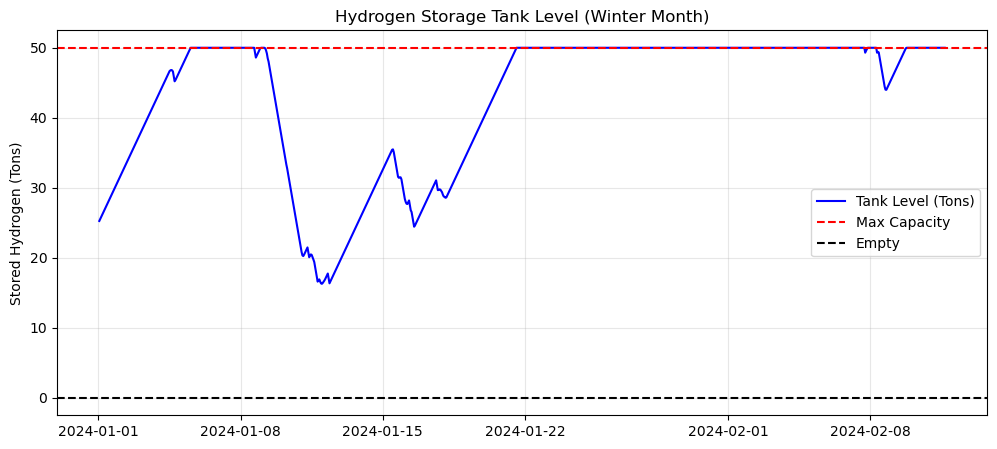

In [23]:
import matplotlib.pyplot as plt

# --- PHASE 6: HYDROGEN STORAGE & RELIABILITY MODEL ---

# 1. Define Storage Assumptions
STORAGE_CAPACITY_TONS = 50    # Size of the tank (Medium size for this scale)
STORAGE_CAPACITY_KG = STORAGE_CAPACITY_TONS * 1000
INITIAL_LEVEL_KG = STORAGE_CAPACITY_KG * 0.5  # Start half full

# 2. Define Customer Demand
#    We assume we signed a contract to deliver a CONSTANT flow.
#    Let's aim to deliver the "Average Production" we calculated earlier.
#    (e.g., 6.3 million kg / 8760 hours = ~720 kg/h)
HOURLY_DEMAND_KG = 700 

# 3. Initialize Variables for the Simulation Loop
storage_level = []
unmet_demand = []
curtailed_h2 = []

current_level = INITIAL_LEVEL_KG

print(f"Simulating Storage Tank ({STORAGE_CAPACITY_TONS} tons) with Demand: {HOURLY_DEMAND_KG} kg/h...")

# 4. Run the Time-Series Loop (Hour by Hour)
#    We iterate through the 'real_h2_kg' column you calculated in Phase 3
for production in df_master['real_h2_kg']:
    
    # A. Calculate Balance
    #    New Level = Old Level + Inflow (Production) - Outflow (Demand)
    next_level = current_level + production - HOURLY_DEMAND_KG
    
    # B. Check Constraints
    
    # Case 1: Tank is Empty (Underflow)
    if next_level < 0:
        shortfall = abs(next_level)
        unmet_demand.append(shortfall)  # We failed to deliver this amount
        curtailed_h2.append(0)
        current_level = 0
        
    # Case 2: Tank is Full (Overflow)
    elif next_level > STORAGE_CAPACITY_KG:
        excess = next_level - STORAGE_CAPACITY_KG
        curtailed_h2.append(excess)     # We wasted this production (tank full)
        unmet_demand.append(0)
        current_level = STORAGE_CAPACITY_KG
        
    # Case 3: Normal Operation
    else:
        unmet_demand.append(0)
        curtailed_h2.append(0)
        current_level = next_level
        
    # Record the level for this hour
    storage_level.append(current_level)

# 5. Add results to DataFrame for plotting
df_master['storage_level_kg'] = storage_level
df_master['unmet_demand_kg'] = unmet_demand

# 6. Calculate Key Performance Indicators (KPIs)
total_demand = HOURLY_DEMAND_KG * 8760
total_delivered = total_demand - sum(unmet_demand)
reliability_pct = (total_delivered / total_demand) * 100

print("\n--- STORAGE SYSTEM RESULTS ---")
print(f"Tank Size:             {STORAGE_CAPACITY_TONS} Tons")
print(f"Constant Demand:       {HOURLY_DEMAND_KG} kg/hour")
print(f"Supply Reliability:    {reliability_pct:.2f}%")
print(f"Total H2 Shortfall:    {sum(unmet_demand):,.0f} kg")
print("-" * 30)

# 7. Visualize the Tank Level (First 1000 Hours)
plt.figure(figsize=(12, 5))
plt.plot(df_master.index[:1000], df_master['storage_level_kg'][:1000] / 1000, label="Tank Level (Tons)", color='blue')
plt.axhline(y=STORAGE_CAPACITY_TONS, color='red', linestyle='--', label="Max Capacity")
plt.axhline(y=0, color='black', linestyle='--', label="Empty")
plt.title("Hydrogen Storage Tank Level (Winter Month)")
plt.ylabel("Stored Hydrogen (Tons)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Optimizing Tank Size (Testing 30 scenarios)...


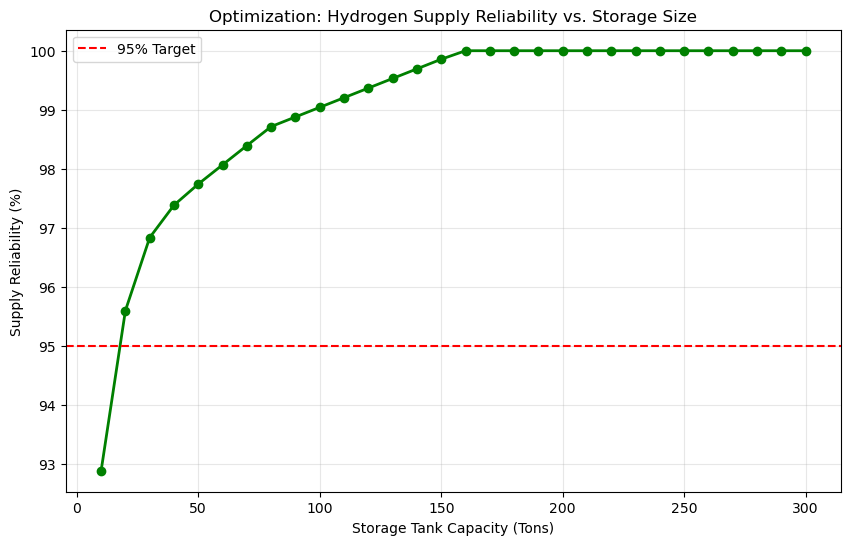

Tank Size (Tons)     | Reliability (%)
----------------------------------------
10                   | 92.88%
20                   | 95.59%
30                   | 96.83%
40                   | 97.38%
50                   | 97.74%
60                   | 98.07%
70                   | 98.39%
80                   | 98.71%
90                   | 98.88%
100                  | 99.04%
110                  | 99.20%
120                  | 99.37%
130                  | 99.53%
140                  | 99.69%
150                  | 99.86%
160                  | 100.00%
170                  | 100.00%
180                  | 100.00%
190                  | 100.00%
200                  | 100.00%
210                  | 100.00%
220                  | 100.00%
230                  | 100.00%
240                  | 100.00%
250                  | 100.00%
260                  | 100.00%
270                  | 100.00%
280                  | 100.00%
290                  | 100.00%
300                  | 100.00%


In [24]:
import numpy as np
import matplotlib.pyplot as plt

# --- PHASE 7: TANK SIZE OPTIMIZATION ---

# 1. Define the Range of Tank Sizes to Test
#    Test from 10 tons to 200 tons in steps of 10
tank_sizes_tons = np.arange(10, 310, 10)
reliability_scores = []

# Constant Demand (Same as before)
HOURLY_DEMAND_KG = 700 
total_annual_demand = HOURLY_DEMAND_KG * 8760

print(f"Optimizing Tank Size (Testing {len(tank_sizes_tons)} scenarios)...")

# 2. Run the Optimization Loop
for capacity_tons in tank_sizes_tons:
    
    capacity_kg = capacity_tons * 1000
    current_level = capacity_kg * 0.5 # Start half full
    unmet_demand_count = 0
    
    # Fast Loop through the year
    for production in df_master['real_h2_kg']:
        next_level = current_level + production - HOURLY_DEMAND_KG
        
        if next_level < 0:
            unmet_demand_count += abs(next_level)
            current_level = 0
        elif next_level > capacity_kg:
            current_level = capacity_kg
        else:
            current_level = next_level
            
    # Calculate Reliability for this specific tank size
    delivered = total_annual_demand - unmet_demand_count
    score = (delivered / total_annual_demand) * 100
    reliability_scores.append(score)

# 3. Plot the Optimization Curve (The "Pareto Frontier")
plt.figure(figsize=(10, 6))
plt.plot(tank_sizes_tons, reliability_scores, marker='o', linestyle='-', color='green', linewidth=2)

# Add a reference line for 95% reliability
plt.axhline(y=95, color='red', linestyle='--', label="95% Target")

plt.title("Optimization: Hydrogen Supply Reliability vs. Storage Size")
plt.xlabel("Storage Tank Capacity (Tons)")
plt.ylabel("Supply Reliability (%)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 4. Print the Data Table
print(f"{'Tank Size (Tons)':<20} | {'Reliability (%)':<15}")
print("-" * 40)
for t, r in zip(tank_sizes_tons, reliability_scores):
    print(f"{t:<20} | {r:.2f}%")

In [16]:
import pandas as pd
import glob
import os

# --- STEP 1: LOAD AND MERGE ALL 12 MONTHS ---

# 1. Define the folder path
folder_path = 'E:/Arbitrage_Model_project/wind-h2-arbitrage/DATA/Redispatched'  # Make sure your files are here!
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

print(f"Found {len(all_files)} monthly files. Merging them now...")

df_list = []

for filename in all_files:
    # Read each file
    # header=0: Use the first row as column names
    # skiprows=[1]: SKIP the second row which contains units like "Energy (MWh)"
    temp_df = pd.read_csv(filename, header=0, skiprows=[1])
    df_list.append(temp_df)

# Concatenate all months into one big DataFrame
df_redispatch = pd.concat(df_list, axis=0, ignore_index=True)

# --- STEP 2: CLEAN AND PROCESS ---

# 1. Rename Columns (Ensure this matches your CSV headers!)
#    (The target column might be different in different files, check this if it fails again)
target_col = 'DE (TenneT) Load decrease (current-induced)' 
if target_col not in df_redispatch.columns:
    # Fallback for some variations in naming
    target_col = 'DE (TenneT) Load decrease (current-induced) [MW]'

df_redispatch = df_redispatch.rename(columns={
    'Date (GMT+1)': 'datetime',
    target_col: 'region_curtailment_mw'
})

# 2. FORCE Conversion to Datetime (The Fix)
#    - utc=True: Handles the mix of +01:00 and +02:00 automatically
#    - errors='coerce': If it finds text like "Energy (MWh)", it turns it into NaT (Not a Time)
df_redispatch['datetime'] = pd.to_datetime(df_redispatch['datetime'], utc=True, errors='coerce')

# 3. Remove "Garbage" Rows
#    Drop any rows where the date conversion failed (the NaT rows)
df_redispatch = df_redispatch.dropna(subset=['datetime'])

# 4. Set Index and Sort
df_redispatch = df_redispatch.set_index('datetime')
df_redispatch = df_redispatch.sort_index()

# 5. Check the Index Type (Sanity Check)
print(f"Index Type: {type(df_redispatch.index)}") 
# It MUST say: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

# 6. Resample to Hourly
#    Now it should work because the index is definitely a DatetimeIndex
df_redispatch_hourly = df_redispatch[['region_curtailment_mw']].resample('H').mean()
df_redispatch_hourly = df_redispatch_hourly.fillna(0)

print("✅ Success! Resampled to hourly.")
print(df_redispatch_hourly.head())

# --- VERIFY THE RESULT ---
print("-" * 30)
print("✅ Merge Complete!")
print(f"Total Hours Loaded: {len(df_redispatch_hourly)}")
print(f"Date Range: {df_redispatch_hourly.index.min()} to {df_redispatch_hourly.index.max()}")

Found 12 monthly files. Merging them now...
Index Type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
✅ Success! Resampled to hourly.
                           region_curtailment_mw
datetime                                        
2023-12-31 23:00:00+00:00                  -10.0
2024-01-01 00:00:00+00:00                  -10.0
2024-01-01 01:00:00+00:00                  -10.0
2024-01-01 02:00:00+00:00                  -10.0
2024-01-01 03:00:00+00:00                  -10.0
------------------------------
✅ Merge Complete!
Total Hours Loaded: 8784
Date Range: 2023-12-31 23:00:00+00:00 to 2024-12-31 22:00:00+00:00


C:\Users\Madhvesh\AppData\Local\Temp\ipykernel_25404\3349298781.py:58: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_redispatch_hourly = df_redispatch[['region_curtailment_mw']].resample('H').mean()


In [25]:
# --- STEP 2: APPLY CURTAILMENT TO YOUR WIND FARM ---

# A. Calculate "Grid Stress Factor" (0% to 100%)
#    We assume the maximum observed regional curtailment represents a "100% Clogged Grid"
max_curtailment = df_redispatch_hourly['region_curtailment_mw'].min() # It's negative numbers!
# Avoid dividing by zero if no curtailment
if max_curtailment == 0:
    max_curtailment = -1 

df_redispatch_hourly['grid_stress'] = df_redispatch_hourly['region_curtailment_mw'] / max_curtailment

# B. Merge into Master DataFrame
#    We use 'left' join to keep our master timeline intact
df_master = df_master.join(df_redispatch_hourly['grid_stress'], how='left')
df_master['grid_stress'] = df_master['grid_stress'].fillna(0)

# C. Calculate Lost Energy
def calculate_physical_curtailment(row):
    wind_mw = row['power_mw']
    stress = row['grid_stress']
    
    # If grid is stressed, capacity is capped
    if stress > 0:
        # Example: If stress is 0.5 (50%), allowed capacity is 50%
        allowed_pct = 1.0 - stress
        curtailment_limit = TOTAL_FARM_CAPACITY_MW * allowed_pct
        
        # Actual generation is the LOWER of Wind Potential vs. Grid Limit
        actual_generation = min(wind_mw, curtailment_limit)
        lost_mw = wind_mw - actual_generation
    else:
        actual_generation = wind_mw
        lost_mw = 0
        
    return pd.Series([actual_generation, lost_mw])

print("Calculating energy lost to grid bottlenecks...")
df_master[['grid_limited_power', 'lost_mwh']] = df_master.apply(calculate_physical_curtailment, axis=1)

# --- STEP 3: RESULTS ---
total_wind_potential = df_master['power_mw'].sum()
total_lost = df_master['lost_mwh'].sum()
pct_lost = (total_lost / total_wind_potential) * 100

print("\n--- GRID CONGESTION ANALYSIS ---")
print(f"Total Wind Potential:    {total_wind_potential:,.0f} MWh")
print(f"Total Energy Lost:       {total_lost:,.0f} MWh")
print(f"Curtailment Rate:        {pct_lost:.2f}%")
print("-" * 30)
print("Interpretation: This 'Lost Energy' is what the Electrolyzer captures!")

Calculating energy lost to grid bottlenecks...

--- GRID CONGESTION ANALYSIS ---
Total Wind Potential:    904,270 MWh
Total Energy Lost:       44,149 MWh
Curtailment Rate:        4.88%
------------------------------
Interpretation: This 'Lost Energy' is what the Electrolyzer captures!
